In [66]:
import pandas as pd
import numpy as np
import os 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

In [67]:
sys.path.insert(1, os.path.join(sys.path[0], '../../../openAi/TS_analysis_TOPIC9/'))

In [68]:
from pyts_utils import proximity_tools

In [69]:
af = pd.read_csv("antifragilidades_datasets/af.csv")
af = af.rename({'Unnamed: 0':'country','Unnamed: 1':'year'},axis=1)
df = pd.read_csv('pairing_data/for_distance_pairing/trade_matrix_final.csv',index_col=0)

In [70]:
df.exporter.unique().shape

(243,)

In [71]:
df.importer.unique().shape

(183,)

Tenemos 184 paises importadores y 244 paises exportadores.

In [72]:
df.head()

,importer,exporter,Item,Element,Year,Unit,Value
0,Afghanistan,Argentina,Maize,Import Quantity,2017,tonnes,130.0
1,Afghanistan,Argentina,Maize,Import Value,2017,1000 US$,68.0
2,Afghanistan,Australia,Rice - total (Rice milled equivalent),Import Quantity,2010,tonnes,32.0
3,Afghanistan,Australia,Rice - total (Rice milled equivalent),Import Value,2010,1000 US$,21.0
4,Afghanistan,Azerbaijan,Rice - total (Rice milled equivalent),Import Quantity,2014,tonnes,16.0


Podria ser el caso que los paises que tenemos mas paises exportadores que importadores debido a que los paises que exportan se puede suponer que lo hacen porque les conviene y les sobra los suficiente para ademas poder exportar. Los importadores podemos pensar que importan porque lo necesitan? Podria significar que los paises que no tienen muchos registros como importadores podrian ser los NO-fragiles debido a que no necesitan importar cosas para estar bien?? Los paises que aparecen como importadores pocas veces, aparecen como exportadores muchas veces? Existe esa simetria?? O son asimetricos y pasa que aunque aparescan pocas veces como importadores, tambien aparecen pocos registros de ellos como exportadores??

<AxesSubplot:>

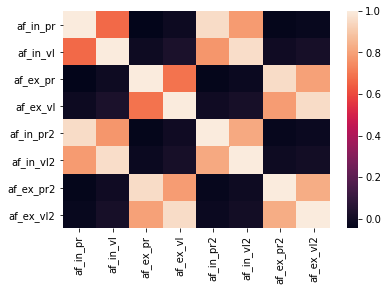

In [73]:
sns.heatmap(af.iloc[:,2:].corr())

In [78]:
ex_pr = af.pivot_table(index='year',columns='country',values='af_ex_pr')

In [79]:
from sklearn.cluster import KMeans

In [80]:
km_clust=KMeans(n_clusters=9).fit(ex_pr.dropna(axis=1).T)

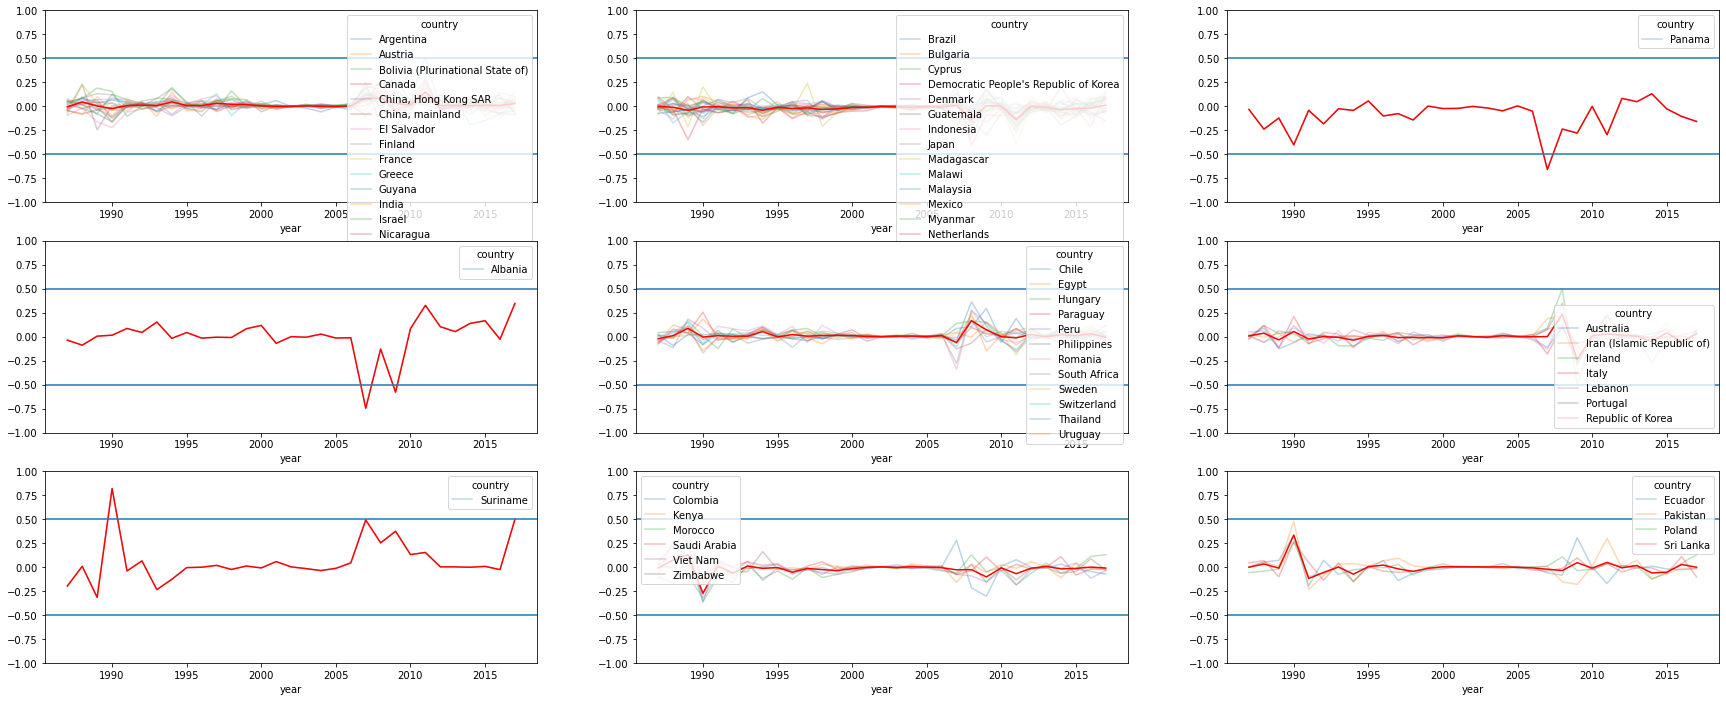

In [81]:
clusters=pd.DataFrame({"country":ex_pr.dropna(axis=1).columns, "cluster":km_clust.labels_})
clusters=clusters.astype('object')

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(30,12))
axes=axes.flatten()
for i in clusters['cluster'].unique():
    cs=clusters[clusters['cluster']==i]['country']
    ex_pr.dropna(axis=1).loc[:,cs.values].plot(alpha=0.3,ylim=(-1,1),ax=axes[i-1])
    ex_pr.dropna(axis=1).loc[:,cs.values].mean(axis=1).plot(c='r',ax=axes[i-1])    
    axes[i-1].axhline(.5)
    axes[i-1].axhline(-.5)
    
# clusters.groupby('cluster').apply(lambda cols: ex_pr.dropna(axis=1).loc[:,cols['country'].values].mean(axis=1).plot(figsize=(20,8)))

In [83]:
from sklearn.preprocessing import power_transform

In [84]:
yeo_johnson=power_transform(ex_pr.dropna(axis=1).T,standardize=False)

/home/rogelio/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [85]:
yeo_johnson = pd.DataFrame(data=yeo_johnson,index=ex_pr.dropna(axis=1).columns.values,columns=ex_pr.dropna(axis=1).index)

In [86]:
from scipy.cluster.hierarchy import linkage,fcluster
import scipy.spatial.distance as sp 

In [14]:
dMI = lambda x,y: proximity_tools.MI(x,y,bins=3)

In [148]:
# distance_c = np.abs(sp.pdist(ex_pr.dropna(axis=1).T,metric='correlation'))
# distance_c=np.abs(sp.pdist(yeo_johnson,metric=proximity_tools.max_xcorr))
distance_c = 1-np.abs(ex_pr.dropna(axis=1,thresh=15).corr())

In [174]:
Z=linkage(sp.squareform(distance_c),method='complete',metric='precomputed')

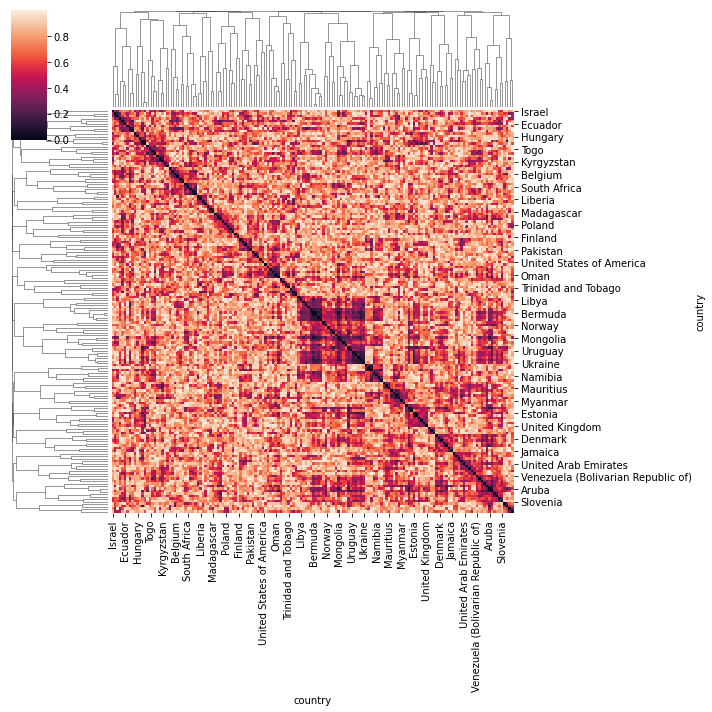

In [175]:
sns.clustermap(distance_c,row_linkage=Z,col_linkage=Z)

In [180]:
labels = fcluster(Z,54,criterion='maxclust')

In [181]:
clusters=pd.DataFrame({"country":ex_pr.dropna(axis=1,thresh=15).columns, "cluster":labels})
clusters=clusters.astype('object')

In [183]:
fig, axes = plt.subplots(nrows=8, ncols=7,figsize=(30,12))
axes=axes.flatten()
for i in clusters['cluster'].unique():
    cs=clusters[clusters['cluster']==i]['country']
    ex_pr.dropna(axis=1,thresh=15).loc[:,cs.values].plot(alpha=0.3,ylim=(-1,1),ax=axes[i-1])
    ex_pr.dropna(axis=1,thresh=15).loc[:,cs.values].mean(axis=1).plot(c='r',ax=axes[i-1])    
    axes[i-1].axhline(.5)
    axes[i-1].axhline(-.5)
plt.savefig('test.png')
plt.close()

In [155]:
grupos = pd.DataFrame({'countries':ex_pr.dropna(axis=1).columns,'labels':labels})

ValueError: arrays must all be same length

labels
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

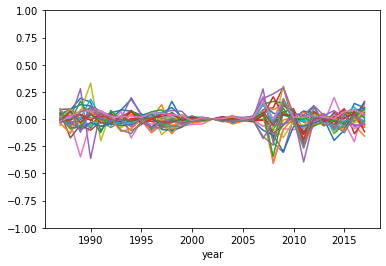

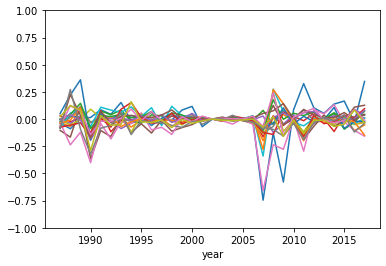

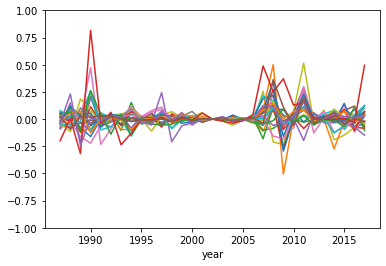

In [23]:
grupos.groupby('labels').apply(lambda cols: ex_pr.loc[:,cols['countries'].values].plot(ylim=(-1,1),legend=False))

labels
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

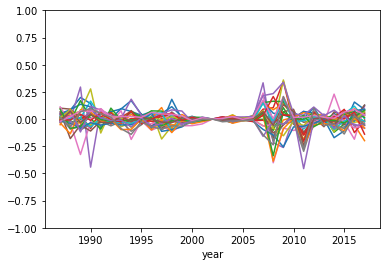

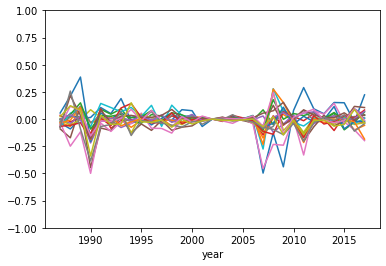

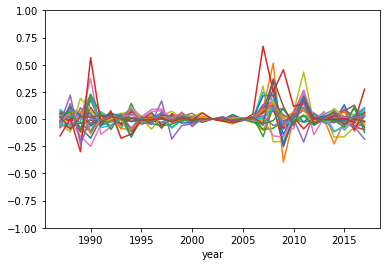

In [22]:
grupos.groupby('labels').apply(lambda cols: yeo_johnson.T.loc[:,cols['countries'].values].plot(ylim=(-1,1),legend=False))

In [64]:
grupos=clusters

In [67]:
grupos=grupos.set_index('country')

In [68]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)

In [69]:
pop=pop.pivot_table(values='value',index='date',columns='country.value')

In [70]:
# pop_clean=pop.T.join(grupos,how='inner')
pop_clean=pop.T.join(yeo_johnson,how='inner',rsuffix='yeo')

<AxesSubplot:>

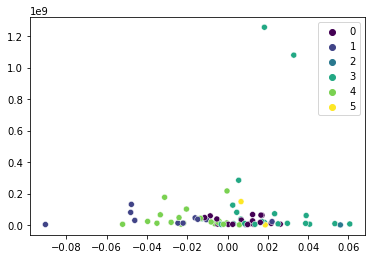

In [73]:
sns.scatterplot(palette='viridis',x=pop_clean.iloc[:,32:].mean(axis=1),y=pop_clean.iloc[:,:32].mean(axis=1),hue=grupos.join(pop_clean,how='inner')['cluster'].values)

/home/rogelio/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


labels
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23    AxesSubplot(0.125,0.125;0.775x0.755)
24  

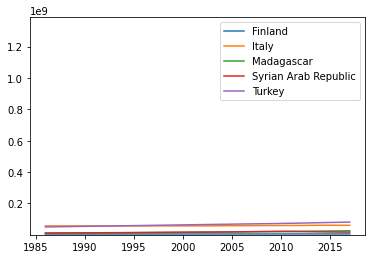

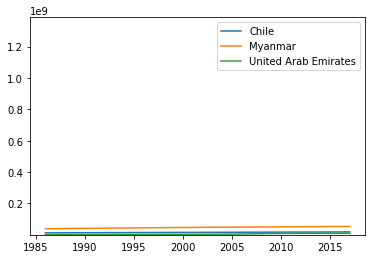

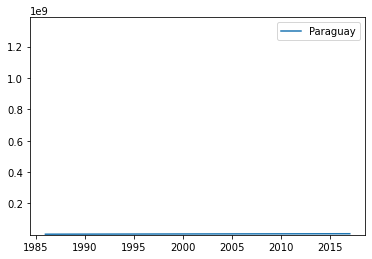

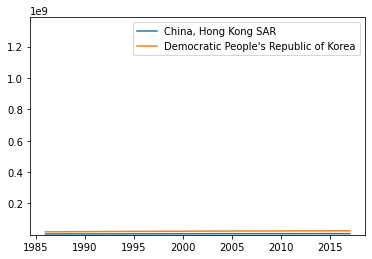

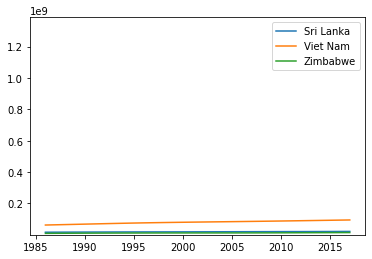

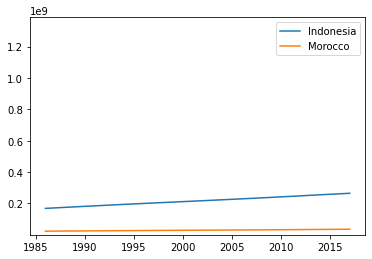

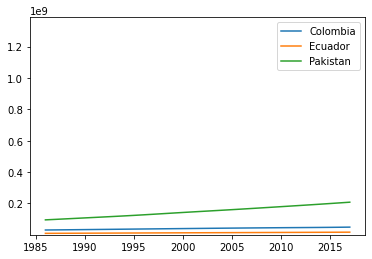

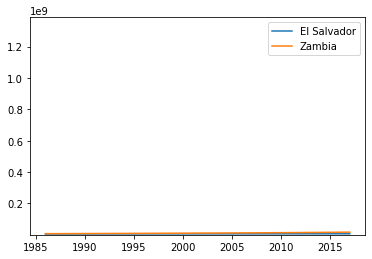

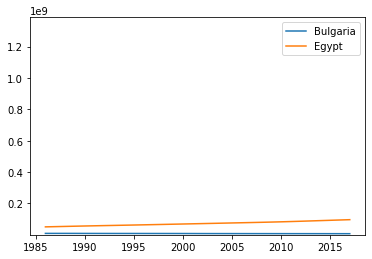

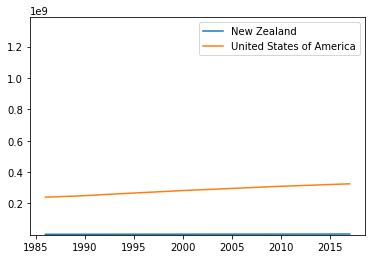

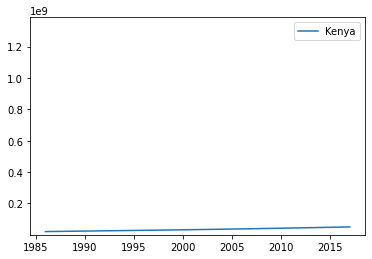

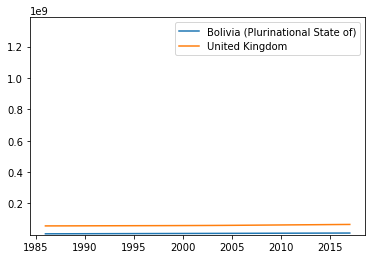

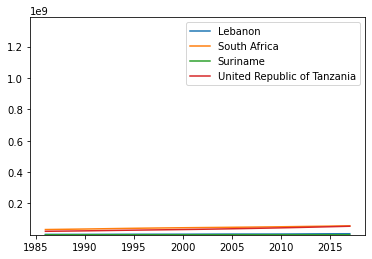

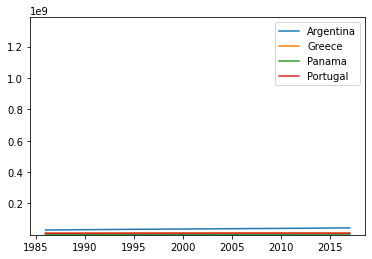

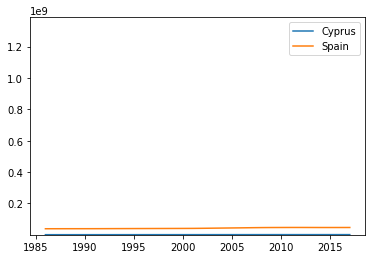

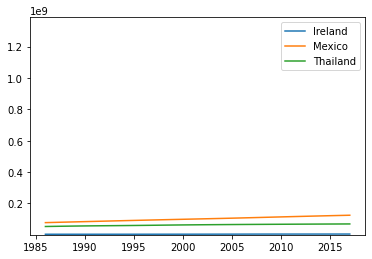

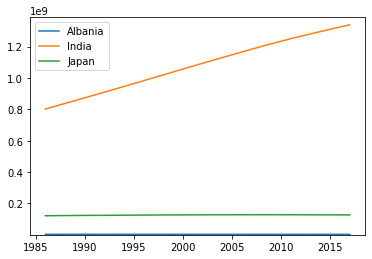

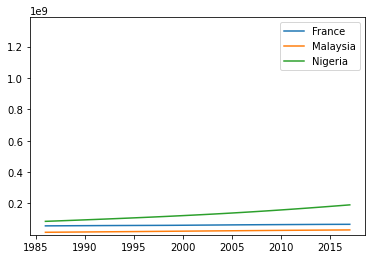

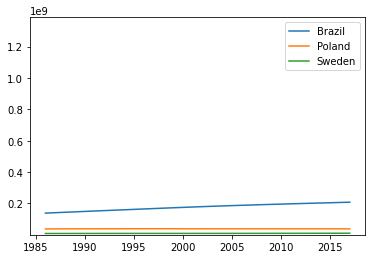

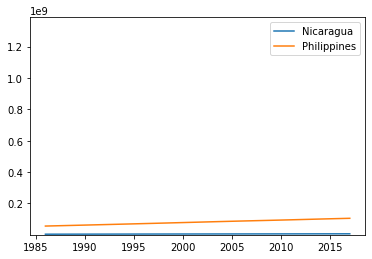

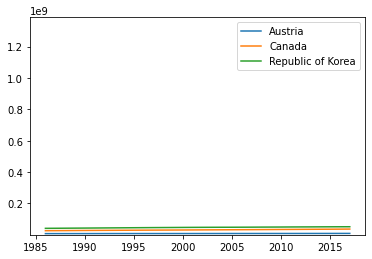

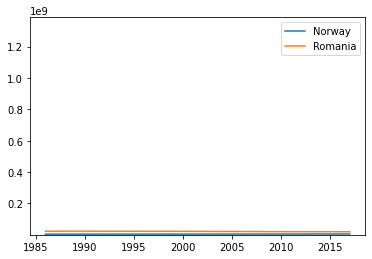

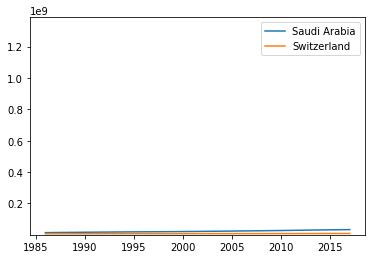

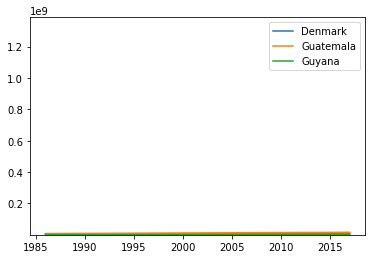

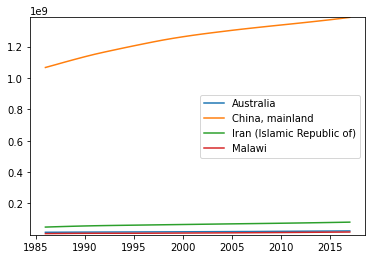

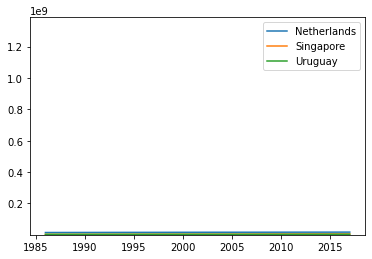

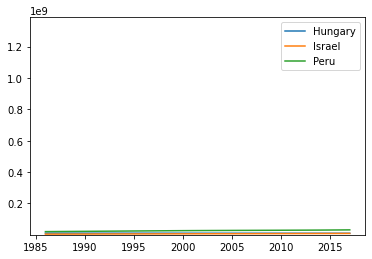

In [166]:
pop_clean.groupby('labels').apply(lambda col: col.T.drop('labels').plot(ylim=(pop_clean.min().min(),pop_clean.max().max())))